In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
import scipy
from shapely.geometry import mapping
from eofs.xarray import Eof
from xarrayutils.utils import linear_trend
import gc
import collections
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves
figures_folderpath = 'reports/figures/' # Folder for output figures

#W_Ross_1_filepath = 'data/interim/region.geojson'

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'

randomized_realizations_path = 'randomized_realizations/'

flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+interim_data_folder+flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')

In [5]:
flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux
h = ssh

Text(0, 0.5, 'Depth')

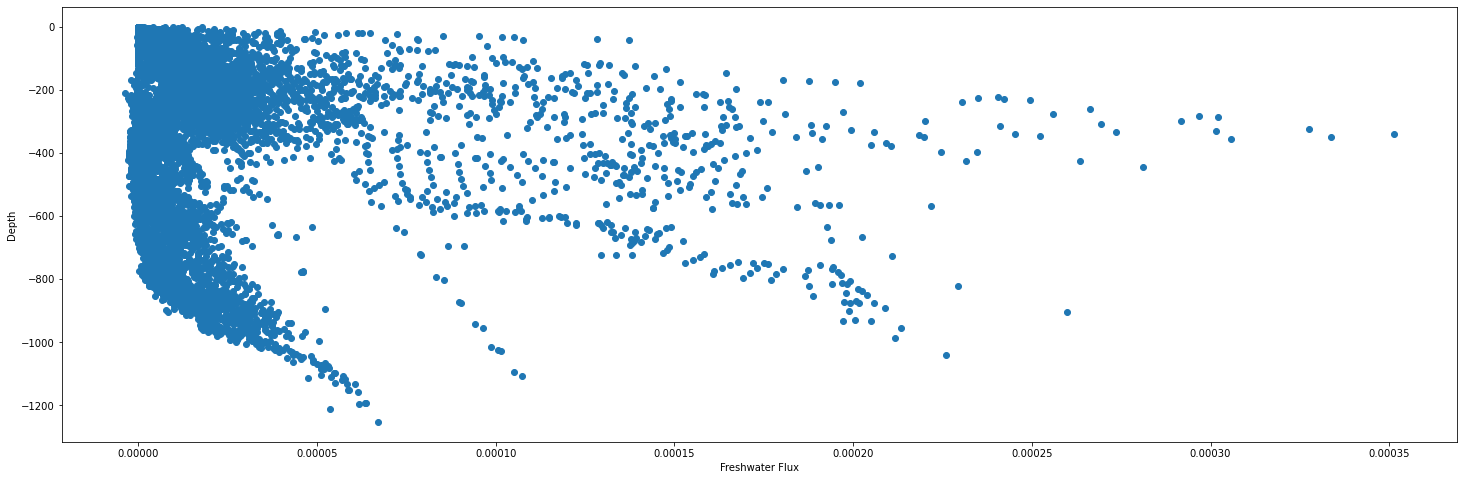

In [11]:
plt.figure(figsize=(25,8))
plt.scatter(flux[1000],h[1000])
plt.xlabel('Freshwater Flux')
plt.ylabel('Depth')

In [6]:
# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [8]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [9]:
# Convert to numpy array for use in Eof.standard interface
# Can be removed once bug in Eof.xarray interface is fixed
spinup_period_years = 25 # Check with LANL team on period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years

# Cut off initial 'model spinup period' data before analysis
#flux_clean_array = flux_clean[spinup_time_period:].to_numpy()

#flux_clean = flux_clean[spinup_time_period:]
flux_clean = flux_anm[spinup_time_period:]

In [10]:
basin = 103
basin_Filchner = 55

In [12]:
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_clean_Filchner = flux_clean.rio.clip(icems.loc[[basin_Filchner],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
c = sm.tsa.stattools.acf(flux_Filchner_series) # time autocorrelation function
f = np.fft.rfft(c) # Fourier transform

In [ ]:
g = np.fft.rfft(flux_Filchner_series)

In [ ]:
gsq = g*g

In [14]:
flux_Filchner_series = flux_clean_Filchner.sum(['y','x'])

In [ ]:
plt.figure(figsize=(25,8))
flux_Filchner_series.plot()

In [16]:
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_clean_basin = flux_clean.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
flux_clean_basin = flux_clean_basin.dropna('time',how='all')
flux_clean_basin = flux_clean_basin.dropna('y',how='all')
flux_clean_basin = flux_clean_basin.dropna('x',how='all')

In [ ]:
%%time
# EOF/PCA analysis
# fluxsolver = Eof(flux_clean_array) # using eof.standard numpy interface
fluxsolver = Eof(flux_clean) # using eof.xarray interface
#fluxsolver = Eof(res)

In [18]:
# Define EOFs and PCs
fluxeofs = fluxsolver.eofs()
fluxpcs = fluxsolver.pcs()

In [ ]:
%%time
# Plot phase randomized data
#plt.figure(figsize=(25, 8), dpi=80)

# spinuptime not required as data has been cut off before performing the EOF/PC decomposition. 
# Set spinuptime = 0
spinuptime = 0 # Ignore first few years of data in the phase randomization 
n_realizations = 2 # Number of random Fourier realizations

#mode_index = 1 # Choose principal component to randomize. interates in range(fluxpcs.mode.values.size)

t_length = fluxpcs.shape[0] # Size 

new_fl = np.empty((n_realizations,fluxpcs.shape[0],fluxpcs.shape[1])) # fluxpcs[:,i] when using PCA outputs

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(fluxsolver.neofs):
        fl = fluxpcs[spinuptime:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}'.format(i))
        #plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

# new_fl = xr.DataArray(new_fl, coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)


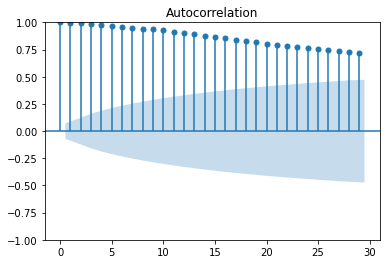

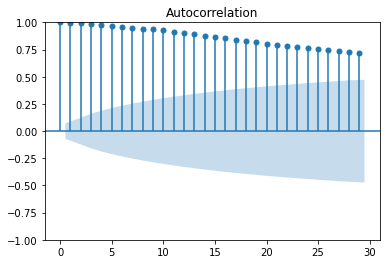

In [118]:
plot_acf(new_fl[0,t1:tf,0])

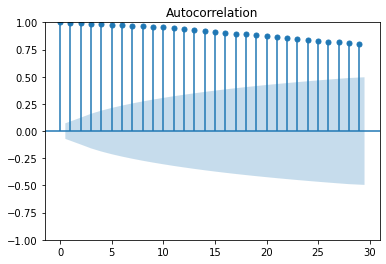

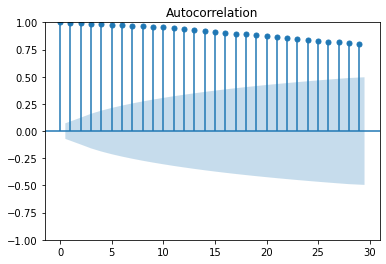

In [119]:
plot_acf(fluxpcs[t1:tf,0])

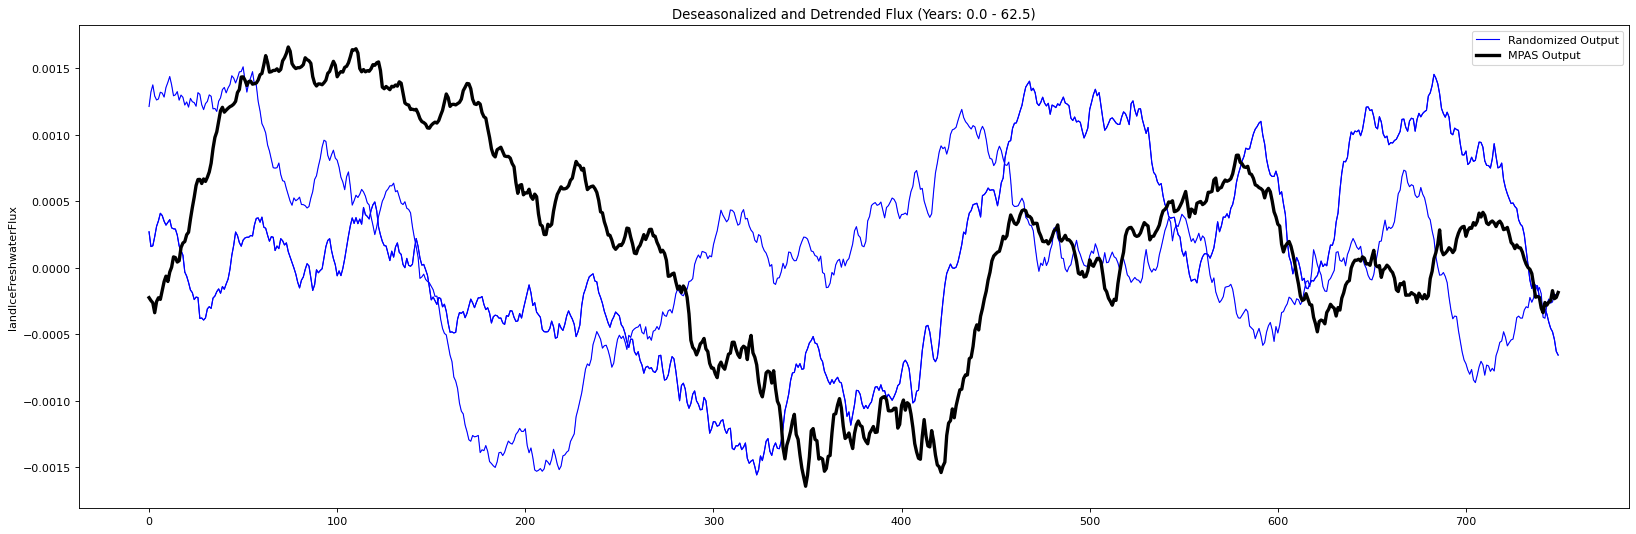

In [20]:
plt.figure(figsize=(25, 8), dpi=80)

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,0],'b', linewidth=0.15)

plt.plot(new_fl[0,t1:tf,0],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[1,t1:tf,0],'b', linewidth=1)
plt.plot(new_fl[0,t1:tf,0],'b', linewidth=1)
plt.plot(fluxpcs[t1:tf,0],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.format((spinuptime+t1)/12,(spinuptime+tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [21]:
def _valid_nan(in_array):
    inan = np.isnan(in_array)
    return (inan.any(axis=0) == inan.all(axis=0)).all()

In [22]:
%%time
### reconstruct field: code optimized
# Store the input data in an instance variable.
if flux_clean.ndim < 2:
    raise ValueError('the input data set must be at least two dimensional')
_data = flux_clean.to_numpy().copy()
# Check if the input is a masked array. If so fill it with NaN.
try:
    _data = _data.filled(fill_value=np.nan)
    _filled = True
except AttributeError:
    _filled = False
# Store information about the shape/size of the input data.
_records = _data.shape[0]
_originalshape = _data.shape[1:]
channels = np.product(_originalshape)
# Remove the time mean of the input data unless explicitly told
# not to by the "center" argument.
# Reshape to two dimensions (time, space) creating the design matrix.
_data = _data.reshape([_records, channels])
# Find the indices of values that are not missing in one row. All the
# rows will have missing values in the same places provided the
# array was centered. If it wasn't then it is possible that some
# missing values will be missed and the singular value decomposition
# will produce not a number for everything.
if not _valid_nan(_data):
    raise ValueError('missing values detected in different '
                     'locations at different times')
nonMissingIndex = np.where(np.logical_not(np.isnan(_data[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = _data[:, nonMissingIndex]
if dataNoMissing.size == 0:
    raise ValueError('all input data is missing')
# Compute the singular value decomposition of the design matrix.
try:
    A, Lh, E = np.linalg.svd(dataNoMissing, full_matrices=False)
except (np.linalg.LinAlgError, ValueError):
    raise ValueError('error encountered in SVD, check that missing '
                     'values are in the same places at each time and '
                     'that all the values are not missing')
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
_ddof = 1 # defaults to 1
normfactor = float(_records - _ddof)
_L = Lh * Lh / normfactor
# Store the number of eigenvalues (and hence EOFs) that were actually
# computed.
neofs = len(_L)
# Re-introduce missing values into the eigenvectors in the same places
# as they exist in the input maps. Create an array of not-a-numbers
# and then introduce data values where required. We have to use the
# astype method to ensure the eigenvectors are the same type as the
# input dataset since multiplication by np.NaN will promote to 64-bit.
_flatE = np.ones([neofs, channels],
                      dtype=_data.dtype) * np.NaN
_flatE = _flatE.astype(_data.dtype)
_flatE[:, nonMissingIndex] = E
# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
#_P = A * Lh

CPU times: user 2min 44s, sys: 57.7 s, total: 3min 42s
Wall time: 54.7 s


In [23]:
%%time
for i in range(n_realizations):
    fluxpcs_new = xr.DataArray(new_fl[i], coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)
    _P = fluxpcs_new.to_numpy()
    if isinstance(neofs, collections.abc.Iterable):
        modes = [m - 1 for m in neofs]
    else:
        modes = slice(0, neofs)
    # Project principal components onto the EOFs to compute the
    # reconstructed field.
    print('Calculating data for realization #{}'.format(i))
    rval = np.dot(_P[:, modes], _flatE[modes])
    # Reshape the reconstructed field so it has the same shape as the
    # input data set.
    rval = rval.reshape((_records,) + _originalshape)

    # Return the reconstructed field.
    if _filled:
        rval = ma.array(rval, mask=np.where(np.isnan(rval), True, False))
    
    reconstr_full = xr.DataArray(rval, dims = flux_clean.dims, coords = flux_clean.coords, attrs = flux_clean.attrs)
    reconstr_full = reconstr_full.rename('timeMonthly_avg_landIceFreshwaterFlux')
    print('Reconstructed data for realization #{}'.format(i))    
    reconstr_full.to_netcdf(inDirName+interim_data_folder+randomized_realizations_path+'Resid_randomized_flux_n_{}'.format(i))
    print('Saved datafile for realization #{}'.format(i))
    del fluxpcs_new, _P, modes, rval, reconstr_full
    print('deleting interim variables')
    gc.collect()

Calculating data for realization #0
Reconstructed data for realization #0
Saved datafile for realization #0
deleting interim variables
Calculating data for realization #1
Reconstructed data for realization #1
Saved datafile for realization #1
deleting interim variables
CPU times: user 3min 28s, sys: 1min 5s, total: 4min 34s
Wall time: 44.9 s


In [24]:
reconstr_full = xr.open_dataset(inDirName+interim_data_folder+randomized_realizations_path+'Resid_randomized_flux_n_{}'.format(0))

In [25]:
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

In [75]:
icems.name.values[103]
basin = 103

In [77]:
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);

orig_basin = flux_clean.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin = flux_reconstr.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [78]:
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')

orig_basin = orig_basin.drop("month")
rec_basin = rec_basin.drop("month")

In [79]:
orig_basin_ts = orig_basin.sum(['y','x'])
rec_basin_ts = rec_basin.sum(['y','x'])

In [80]:
# Vectorize for F-test, Levene-test
orig_basin_vec = orig_basin.stack(z=('x', 'y','time')).dropna('z',how='any').to_numpy()
rec_basin_vec = rec_basin.stack(z=('x', 'y','time')).dropna('z',how='any').to_numpy()

Text(0.5, 1.0, 'Sample Basin: Ronne')

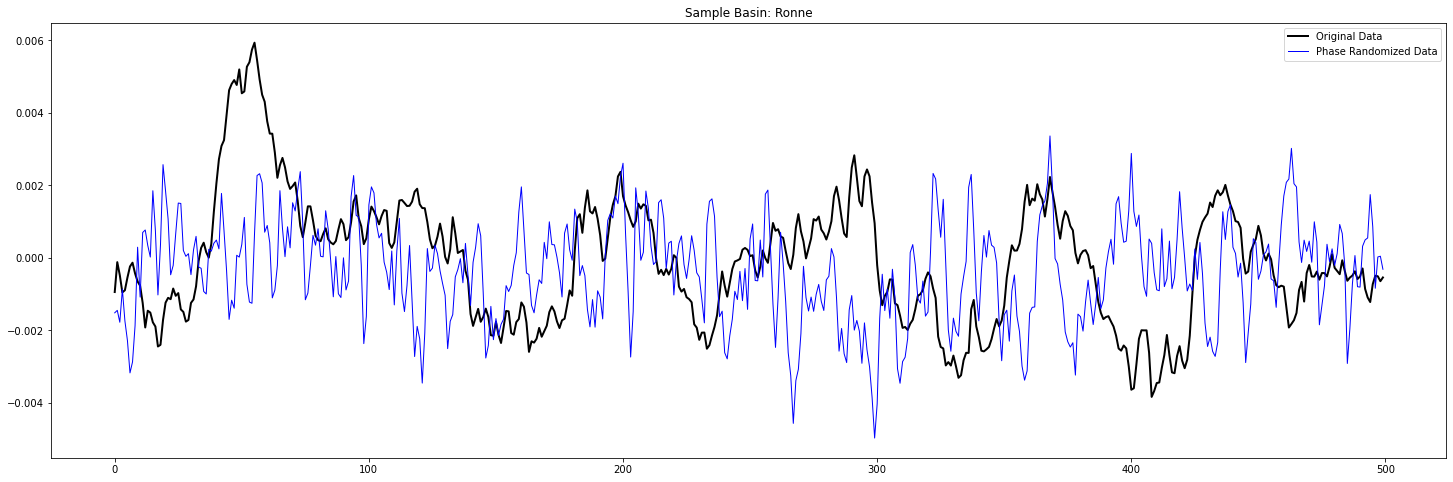

In [97]:
plt.figure(figsize=(25,8))
plt.plot(orig_basin_ts[0:500], 'k', linewidth=2, label = 'Original Data')
plt.plot(rec_basin_ts[0:500], 'b', linewidth=1, label = 'Phase Randomized Data')
plt.legend()
plt.title('Sample Basin: Ronne')

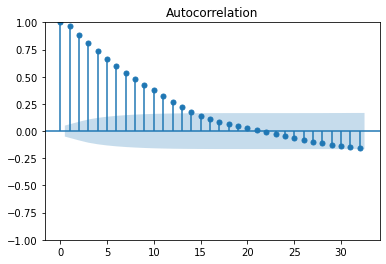

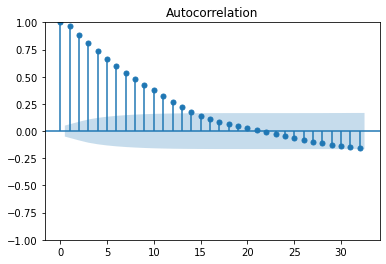

In [116]:
plot_acf(orig_basin[:,10,40])

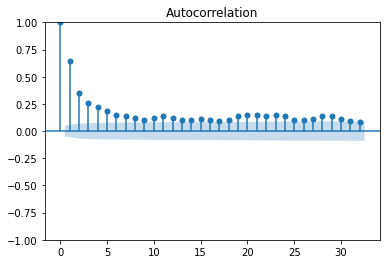

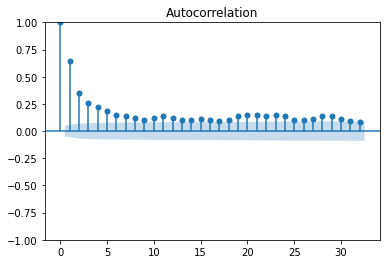

In [117]:
plot_acf(rec_basin[:,10,40])

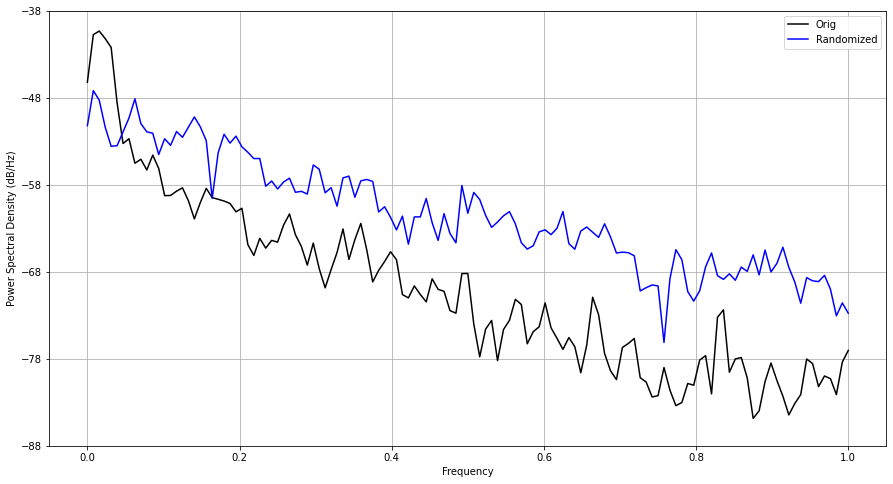

In [95]:
plt.figure(figsize=(15,8))
plt.psd(orig_basin_ts,label='Original', color='k')
plt.psd(rec_basin_ts,label='Randomized', color = 'b')
#plt.psd(flux_ais_basin_ts,label='Randomized (total AIS input)')
plt.legend()

# Statistical equivalence tests

## 1. F-test of equality of variances

In [83]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [84]:
f_test(orig_basin_vec, rec_basin_vec)

(1.0305031002665082, 1.1102230246251565e-16)

In [85]:
from scipy.stats import levene
stat, p = levene(orig_basin_vec, rec_basin_vec)

In [86]:
stat

214.4346126872128

In [87]:
p

1.4818022375079805e-48

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(2,2,figsize=(20,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values

#colorbarmax = np.nanmax([orig_basin,rec_basin])
#colorbarmin = np.nanmin([orig_basin,rec_basin])

plt.subplot(221)
cax1 = orig_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', #vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Original Data", color= 'black', fontweight='bold')


plt.subplot(222)
cax2 = rec_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', #vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data", color= 'blue')

plt.subplot(2,2,(3,4))
cax3, = plt.plot(orig_basin_ts, 'k', linewidth=2, label = 'Original Data')
cax4, = plt.plot(rec_basin_ts,  'b', linewidth=1, label = 'Phase Randomized Data')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig_basin[frame,:,:].values.flatten())
    #ax.set_title('Original Simulation')
    cax2.set_array(rec_basin[frame,:,:].values.flatten())
    #ax.set_title("time = " + str(rec_ameryn.coords['time'].values[frame])[:7])
    #fig.set_title('Phase Randomized Emulation')
    #cax3.set_array(orig_ameryn_ts[frame-2:frame+2].values.flatten())
    #cax3.set_array(orig_ameryn[frame].values.flatten())
    cax3.set_ydata(orig_basin_ts[:frame]) # ANIMATED
    cax3.set_xdata(range(frame)) # ANIMATED
    cax3.set_marker('.')
    cax3.set_markersize(0.25)
    cax4.set_ydata(rec_basin_ts[:frame])
    cax4.set_xdata(range(frame))
    cax4.set_marker('.')
    cax4.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_basin_ts[0:50]),  # Could also be iterable or list
    interval=100     # ms between frames
)

In [ ]:
HTML(ani2.to_jshtml())
#ani2.save(inDirName+figures_folderpath+'{}_comparison_masked_input_data.mp4'.format(icems.name.values[basin]))

In [20]:
###### FULL DATASET DECOMPOSITION ###########

aisfluxeofs = xr.open_dataset(inDirName + interim_data_folder+'fluxeofs.nc').eofs
aisfluxpcs = xr.open_dataset(inDirName + interim_data_folder+'fluxpcs.nc').pcs

In [24]:
aisfluxpcs.shape

(1560, 1560)

In [19]:
aisfluxsolver = Eof(flux_clean)


KeyboardInterrupt



In [ ]:
aisfluxeofs = aisfluxsolver.eofs()
aisfluxpcs = aisfluxsolver.pcs()

In [ ]:
%%time
# Plot phase randomized data
#plt.figure(figsize=(25, 8), dpi=80)

# spinuptime not required as data has been cut off before performing the EOF/PC decomposition. 
# Set spinuptime = 0
spinuptime = 0 # Ignore first few years of data in the phase randomization 
n_realizations = 2 # Number of random Fourier realizations

mode_index = 1 # Choose principal component to randomize. interates in range(fluxpcs.mode.values.size)

t_length = aisfluxpcs[spinuptime:,mode_index].size

new_fl = np.empty((n_realizations,aisfluxpcs.shape[0],aisfluxpcs.shape[1])) # fluxpcs[:,i] when using PCA outputs

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(aisfluxeofs.shape[0]): # aisfluxsolver.neofs
        fl = aisfluxpcs[spinuptime:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}'.format(i))
        #plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

# new_fl = xr.DataArray(new_fl, coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)


In [26]:
%%time
### reconstruct field: code optimized
# Store the input data in an instance variable.
if flux_clean.ndim < 2:
    raise ValueError('the input data set must be at least two dimensional')
_data = flux_clean.to_numpy().copy()
# Check if the input is a masked array. If so fill it with NaN.
try:
    _data = _data.filled(fill_value=np.nan)
    _filled = True
except AttributeError:
    _filled = False
# Store information about the shape/size of the input data.
_records = _data.shape[0]
_originalshape = _data.shape[1:]
channels = np.product(_originalshape)
# Remove the time mean of the input data unless explicitly told
# not to by the "center" argument.
# Reshape to two dimensions (time, space) creating the design matrix.
_data = _data.reshape([_records, channels])
# Find the indices of values that are not missing in one row. All the
# rows will have missing values in the same places provided the
# array was centered. If it wasn't then it is possible that some
# missing values will be missed and the singular value decomposition
# will produce not a number for everything.
if not _valid_nan(_data):
    raise ValueError('missing values detected in different '
                     'locations at different times')
nonMissingIndex = np.where(np.logical_not(np.isnan(_data[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = _data[:, nonMissingIndex]
if dataNoMissing.size == 0:
    raise ValueError('all input data is missing')
# Compute the singular value decomposition of the design matrix.
try:
    A, Lh, E = np.linalg.svd(dataNoMissing, full_matrices=False)
except (np.linalg.LinAlgError, ValueError):
    raise ValueError('error encountered in SVD, check that missing '
                     'values are in the same places at each time and '
                     'that all the values are not missing')
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
_ddof = 1 # defaults to 1
normfactor = float(_records - _ddof)
_L = Lh * Lh / normfactor
# Store the number of eigenvalues (and hence EOFs) that were actually
# computed.
neofs = len(_L)
# Re-introduce missing values into the eigenvectors in the same places
# as they exist in the input maps. Create an array of not-a-numbers
# and then introduce data values where required. We have to use the
# astype method to ensure the eigenvectors are the same type as the
# input dataset since multiplication by np.NaN will promote to 64-bit.
_flatE = np.ones([neofs, channels],
                      dtype=_data.dtype) * np.NaN
_flatE = _flatE.astype(_data.dtype)
_flatE[:, nonMissingIndex] = E
# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
#_P = A * Lh

NameError: name '_valid_nan' is not defined

In [ ]:
%%time
for i in range(n_realizations):
    fluxpcs_new = xr.DataArray(new_fl[i], coords=fluxpcs.coords, dims = fluxpcs.dims, attrs=fluxpcs.attrs)
    _P = fluxpcs_new.to_numpy()
    if isinstance(neofs, collections.abc.Iterable):
        modes = [m - 1 for m in neofs]
    else:
        modes = slice(0, neofs)
    # Project principal components onto the EOFs to compute the
    # reconstructed field.
    print('Calculating data for realization #{}'.format(i))
    rval = np.dot(_P[:, modes], _flatE[modes])
    # Reshape the reconstructed field so it has the same shape as the
    # input data set.
    rval = rval.reshape((_records,) + _originalshape)

    # Return the reconstructed field.
    if _filled:
        rval = ma.array(rval, mask=np.where(np.isnan(rval), True, False))
    
    reconstr_full = xr.DataArray(rval, dims = flux_clean.dims, coords = flux_clean.coords, attrs = flux_clean.attrs)
    reconstr_full = reconstr_full.rename('timeMonthly_avg_landIceFreshwaterFlux')
    print('Reconstructed data for realization #{}'.format(i))    
    reconstr_full.to_netcdf(inDirName+interim_data_folder+randomized_realizations_path+'AIS_TEST_randomized_flux_n_{}.nc'.format(i))
    print('Saved datafile for realization #{}'.format(i))
    del fluxpcs_new, _P, modes, rval, reconstr_full
    print('deleting interim variables')
    gc.collect()

In [ ]:
reconstr_full = xr.open_dataset(inDirName+interim_data_folder+randomized_realizations_path+'AIS_TEST_randomized_flux_n_{}.nc'.format(0))
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);

orig_basin = flux_clean.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin = flux_reconstr.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')

In [ ]:
orig_basin = orig_basin.drop("month")
rec_basin = rec_basin.drop("month")

orig_basin_ts = orig_basin.sum(['y','x'])
rec_basin_ts = rec_basin.sum(['y','x'])

In [ ]:
ais_reconstructed = xr.open_dataset(inDirName + interim_data_folder+randomized_realizations_path+'randomized_flux_n_0')

In [ ]:
flux_ais = ais_reconstructed.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
flux_ais.rio.write_crs("epsg:3031",inplace=True);
flux_ais_basin = flux_ais.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
flux_ais_basin = flux_ais_basin.dropna('time',how='all')
flux_ais_basin = flux_ais_basin.dropna('y',how='all')
flux_ais_basin = flux_ais_basin.dropna('x',how='all')

In [ ]:
flux_ais_basin = flux_ais_basin.drop("month")
flux_ais_basin_ts = flux_ais_basin.sum(['y','x'])

In [ ]:
flux_ais_basin_tmean = flux_ais_basin_ts.mean()

In [ ]:
flux_ais_basin_ts = flux_ais_basin_ts - flux_ais_basin_tmean

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(2,3,figsize=(20,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values

colorbarmax = np.nanmax([orig_basin,rec_basin,flux_ais_basin])
colorbarmin = np.nanmin([orig_basin,rec_basin,flux_ais_basin])

plt.suptitle('Ronne Ice Shelf: Flux Data Reconstruction')
plt.subplot(231)
cax1 = orig_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Original Data", color= 'black', fontweight='bold')


plt.subplot(232)
cax2 = rec_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data (within basin)", color= 'blue')

plt.subplot(233)
cax3 = flux_ais_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data (across AIS)", color= 'red')


#plt.subplot(2,3,[4,5,6])
plt.subplot(212)
cax4, = plt.plot(orig_basin_ts, 'k', linewidth=1.5, label = 'Original Data')
cax5, = plt.plot(rec_basin_ts,  'b', linewidth=0.55, label = 'Phase Randomized Data (within basin)')
cax6, = plt.plot(flux_ais_basin_ts,  'b', linewidth=0.15, label = 'Phase Randomized Data (across AIS)')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig_basin[frame,:,:].values.flatten())
    cax2.set_array(rec_basin[frame,:,:].values.flatten())
    cax3.set_array(flux_ais_basin[frame,:,:].values.flatten())
    cax4.set_ydata(orig_basin_ts[:frame]) # ANIMATED
    cax4.set_xdata(range(frame)) # ANIMATED
    cax4.set_marker('.')
    cax4.set_markersize(0.25)
    cax5.set_ydata(rec_basin_ts[:frame])
    cax5.set_xdata(range(frame))
    cax5.set_marker('.')
    cax5.set_markersize(0.25)
    cax6.set_ydata(flux_ais_basin_ts[:frame])
    cax6.set_xdata(range(frame))
    cax6.set_marker('.')
    cax6.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_basin_ts),  # Could also be iterable or list
    interval=100     # ms between frames
)

In [ ]:
#HTML(ani2.to_jshtml())
ani2.save(inDirName+figures_folderpath+'{}_basinEOF_comparison.mp4'.format(icems.name.values[basin]))

In [ ]:
colorbarmax = np.nanmax([fluxeofs[0:2]])
colorbarmin = np.nanmin([fluxeofs[0:2]])

p = fluxeofs[0:2].plot(col='mode', 
                    col_wrap=2, 
                    sharey=True,
                    robust=False,
                    figsize=[25, 10],
                    subplot_kws={'projection': ccrs.SouthPolarStereo()})

#for ax in p.axes.flat:
#    ax.coastlines()

In [ ]:
plt.figure(figsize=(25,10))
Ronne_eofs[1100].plot(robust=True,subplot_kws={'projection': ccrs.SouthPolarStereo()})

In [ ]:
plt.figure(figsize=(25,8))
plt.psd(fluxpcs[0])
plt.psd(fluxpcs[1])
plt.psd(fluxpcs[10])

In [ ]:
mod_flux_clean = fluxsolver.projectField(flux_clean, neofs=1)

In [ ]:
rgrs = linear_trend(flux_clean,'time')

In [ ]:
mr_rgrs = flux_clean*rgrs.slope + rgrs.intercept

In [ ]:
mr_rgrs.sum(['y','x']).plot()

In [ ]:
res = flux_clean - mr_rgrs

In [ ]:
plt.figure(figsize=(25,8))
res.sum(['y','x']).plot()
flux_clean.sum(['y','x']).plot()

In [ ]:
fluxeofs[0].shape

In [ ]:
fluxeofs[100:120].plot(col='mode', 
                    col_wrap=5, 
                    sharey=True, 
                    figsize=[20, 10],
                    subplot_kws={'projection': ccrs.SouthPolarStereo()})

In [ ]:
from scipy import signal

In [ ]:
plt.psd(orig_basin_ts,label='Orig')
plt.psd(rec_basin_ts,label='Randomized (basin input)')
plt.psd(flux_ais_basin_ts,label='Randomized (total AIS input)')
plt.legend()

In [ ]:
fluxeofs.rio.write_crs("epsg:3031",inplace=True);
Ronne_eofs = fluxeofs.rio.clip(icems.loc[[103],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
Ronne_eofs = Ronne_eofs.dropna('mode',how='all')
Ronne_eofs = Ronne_eofs.dropna('y',how='all')
Ronne_eofs = Ronne_eofs.dropna('x',how='all')

In [ ]:
# CALCULATE CORR COEF between original PCs
# fldgen algorithm
# assumptions going into the method - are they valid?
# 